In [1]:
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sns
from matplotlib import gridspec
from gstatot import StatOT, gStatOT, utils 

sns.set_context("paper", font_scale=1.5)
sns.set_theme(style="ticks")

data_dir = '../data/sim_data/'

In [2]:
key = 42 # seed for random number generator
n = 10 # number of cells per time point

sim_adata = sc.read_h5ad(f"{data_dir}/bistable_sim_0.h5ad")
T = 25  # number of ages to sample for fitting
first_time = 2.0
final_time = 99.0
chosen_times = np.linspace(first_time, final_time, T, dtype=int)

# trajectory sampling parameters
sim_dt = dt =  0.01
num_step = int(2/dt) # 2 days
num_traj = sim_adata.uns['traj_data']['0.0'].shape[0] # 500 

adata_keys  = {'time_key': 'age', # key in adata.obs for age annotation
               'cell_type_key': 'cell_type', # key in adata.obs for cell type annotation
               'growth_rate_key': 'growth_rate', # key in adata.obs for cell growth rates
               'embed_key': 'X_pca'}

down_sampled_adata, _ = utils.downsample_adata_by_age(sim_adata, n=n, time_key='age', PRNG_KEY=key, chosen_times=chosen_times)

gSOT = gStatOT(adata=down_sampled_adata.copy(), adata_keys=adata_keys, dt=dt, cost_scaling='mean', dtype=jnp.float64)

model_params = {'lam': 20,
                'w' : 1.0,
                'epsilon2': 0.015,
                'epsilon1': 0.005,
                'epsilon3': 0.005,
                'r': 0.1} # scaling on entropic OT loss

gSOT.fit(model_params=model_params, max_iter=100_000, verbose=False, constraint_tol=1e-4, solver_kwargs={'inner_iter':10_000})
gSOT.get_lin_fate_probs(label_key=adata_keys['cell_type_key'], all_labels=np.unique(sim_adata.obs[adata_keys['cell_type_key']]))
gSOT.get_trajectories(num_step=num_step, num_traj=num_traj, plot_traj=False)

print("\nFitting StatOT...")
SOT = StatOT(adata=down_sampled_adata.copy(), adata_keys=adata_keys, dt=dt, dtype=jnp.float32)

SOT_params = {'epsilon': 0.15,
             'lse': True,
             'cost_scaling': 'mean'}

SOT.fit(model_params=SOT_params, max_iter=15_000, verbose=False)
SOT.get_lin_fate_probs(label_key=adata_keys['cell_type_key'], all_labels=np.unique(sim_adata.obs[adata_keys['cell_type_key']]))
SOT.get_trajectories(num_step=num_step, num_traj=num_traj, plot_traj=False)

Cost scaled by mean
Ran 70000 iterations in 1.06 minutes.
Final objective value: -1.1080e-01
grad norm: 2.605e-04
max constraint error: 8.474e-05
ended in failed line search: False

Fitting StatOT...
No sinks at time 6.0, cannot compute fate probabilities.
No sinks at time 10.0, cannot compute fate probabilities.
No sinks at time 14.0, cannot compute fate probabilities.
No sinks at time 42.0, cannot compute fate probabilities.
No sinks at time 74.0, cannot compute fate probabilities.


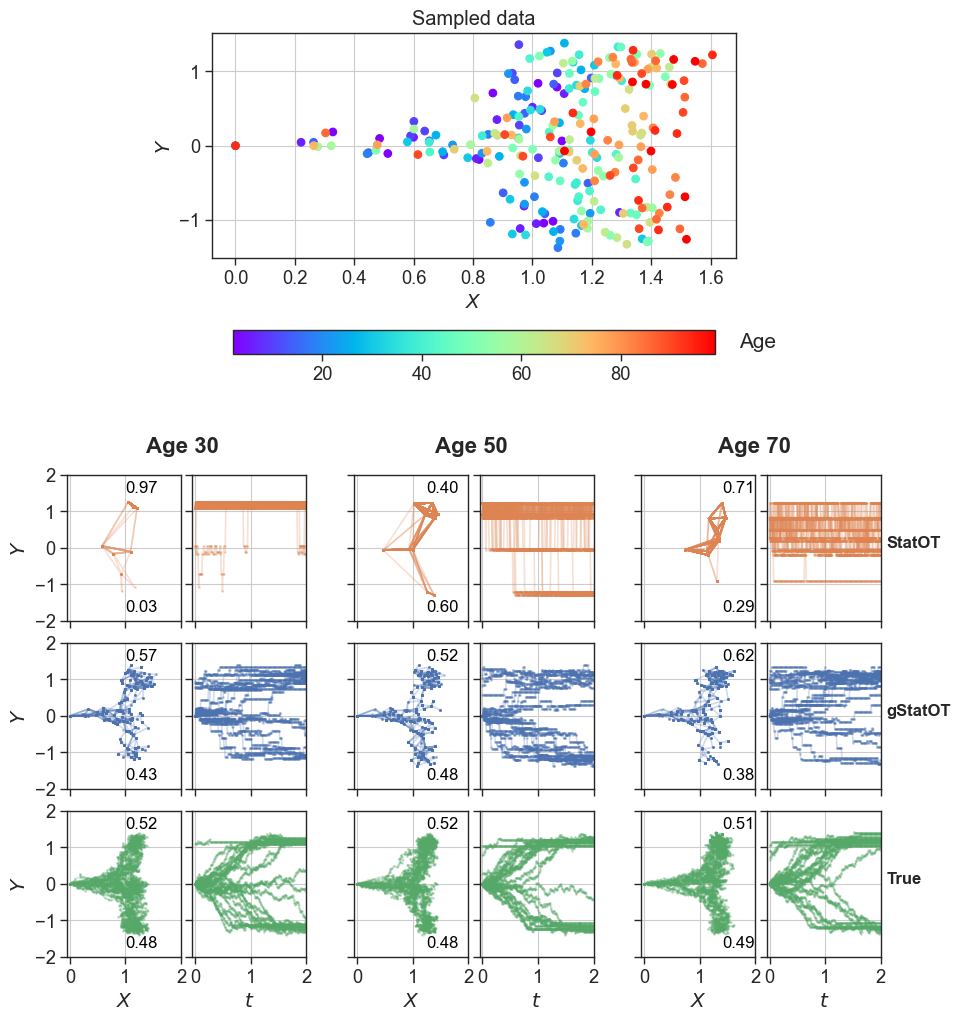

In [5]:
def get_prop(adata):
    ages = adata.obs['age'].unique()
    prop = np.zeros((len(ages), 2))
    for i, a in enumerate(ages):
        traj_data = adata.uns['traj_data'][str(a)][:,-1,1]
        prop[i,0] = np.sum(traj_data > 0) / traj_data.shape[0]
        prop[i,1] = np.sum(traj_data < 0) / traj_data.shape[0]
    prop_df = pd.DataFrame(prop, columns=['+y', '-y'], index=ages)
    return prop_df

gStatOT_traj = gSOT.adata.uns['traj_data']
statOT_traj = SOT.adata.uns['traj_data']
true_traj = sim_adata.uns['traj_data']
mult = int(dt/sim_dt)
prop_true = get_prop(sim_adata)
prop_df_StatOT = get_prop(SOT.adata)
prop_df_gStatOT = get_prop(gSOT.adata)
times = np.array([str(age) for age in [30.0, 50.0, 70.0]])

alpha = 0.25
num_trajectories = 25
marker = 'o'
marker_size = 1

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)

color1 = sns.color_palette("deep", n_colors=3)[1]
color2 = sns.color_palette("deep", n_colors=3)[0]
color3 = sns.color_palette("deep", n_colors=3)[2]

fig = plt.figure(figsize=(3*3 + 1.5, 3*3 + 3))
outer_gs = gridspec.GridSpec(
    nrows=2, ncols=1, height_ratios=[0.4, 0.6], hspace=0.3
)

ax_top = fig.add_subplot(outer_gs[0, 0])
data = down_sampled_adata.X
age = down_sampled_adata.obs['age'].to_numpy()
cmap = 'rainbow'

ax_top.set_aspect(0.25)
im = ax_top.scatter(data[:,0], data[:,1], c=age, cmap=cmap, s=30, alpha=1)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.grid()

ax_top.set_title('Sampled data')

cbar = fig.colorbar(im, orientation="horizontal", ax=ax_top)
pos = cbar.ax.get_position()         
new_height = pos.height * 0.5       
cbar.ax.set_position([pos.x0, pos.y0, pos.width, new_height])

cbar.ax.text(1.05, 0.5, "Age", transform=cbar.ax.transAxes,
             va='center', ha='left', fontsize=15)

mid_gs = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer_gs[1, 0], hspace=0.33)
inner_gs_0 = gridspec.GridSpecFromSubplotSpec(
    3, 2, subplot_spec=mid_gs[0, 0], hspace=0.15, wspace=0.1)
inner_gs_1 = gridspec.GridSpecFromSubplotSpec(
    3, 2, subplot_spec=mid_gs[0, 1], hspace=0.15, wspace=0.1)
inner_gs_2 = gridspec.GridSpecFromSubplotSpec(
    3, 2, subplot_spec=mid_gs[0, 2], hspace=0.15, wspace=0.1)

axes_0 = np.empty((3, 3), dtype=object)
axes_1 = np.empty((3, 3), dtype=object)
axes_2 = np.empty((3, 3), dtype=object)

for i in range(len(times)):
    for j in range(2):
        axes_0[i, j] = fig.add_subplot(inner_gs_0[i, j])
        axes_1[i, j] = fig.add_subplot(inner_gs_1[i, j])
        axes_2[i, j] = fig.add_subplot(inner_gs_2[i, j])

        if i != 2:
            axes_0[i, j].set_xticklabels([])
            axes_1[i, j].set_xticklabels([])
            axes_2[i, j].set_xticklabels([])

        if j > 0 :
            axes_0[i, j].set_yticklabels([])

        axes_1[i, j].set_yticklabels([])
        axes_2[i, j].set_yticklabels([])
        
colors = sns.color_palette("deep", n_colors=3)
col_tuple = (colors[1],
             colors[0],
             colors[2])
color_dict = {0: col_tuple,
              1: col_tuple,
              2: col_tuple}

ax_list = [axes_0, axes_1, axes_2]

for j, age in enumerate(times):
    axes = ax_list[j]   
    for i in range(num_trajectories):
        axes[0, 0].plot(statOT_traj[age][i][:, 0], statOT_traj[age][i][:, 1], color=color_dict[j][0], alpha=alpha, marker=marker, markersize=marker_size)

        steps = true_traj[times[j]].shape[1]
        gOT_traj = gStatOT_traj[age][i][ :int(steps)]
        true_traj_ = true_traj[times[j]][i, :gOT_traj.shape[0], :]

        axes[2, 0].plot(true_traj_[:, 0], true_traj_[:, 1], color=color_dict[j][2], alpha=alpha, marker=marker, markersize=marker_size)
        axes[1, 0].plot(gOT_traj[:, 0], gOT_traj[:, 1], color=color_dict[j][1], alpha=alpha, marker=marker, markersize=marker_size)


    # add proportion text to +y and -y on each  
    if j == 0:
        axes[0, 0].text(1.0,  1.52, f"{prop_df_StatOT.loc[float(age), '+y']:.2f}", fontsize=12, color="black")
        axes[0, 0].text(1.0, -1.75, f"{prop_df_StatOT.loc[float(age), '-y']:.2f}", fontsize=12, color="black")

        axes[1, 0].text(1.0,  1.52, f"{prop_df_gStatOT.loc[float(age), '+y']:.2f}", fontsize=12, color="black")
        axes[1, 0].text(1.0, -1.75, f"{prop_df_gStatOT.loc[float(age), '-y']:.2f}", fontsize=12, color="black")

        axes[2, 0].text(1.0,  1.52, f"{prop_true.loc[float(age), '+y']:.2f}", fontsize=12, color="black")
        axes[2, 0].text(1.0, -1.75, f"{prop_true.loc[float(age), '-y']:.2f}", fontsize=12, color="black")


    if j == 1:
        axes[0, 0].text(1.25,  1.52, f"{prop_df_StatOT.loc[float(age), '+y']:.2f}", fontsize=12, color="black")
        axes[0, 0].text(1.25, -1.75, f"{prop_df_StatOT.loc[float(age), '-y']:.2f}", fontsize=12, color="black")

        axes[1, 0].text(1.25,  1.52, f"{prop_df_gStatOT.loc[float(age), '+y']:.2f}", fontsize=12, color="black")
        axes[1, 0].text(1.25, -1.75, f"{prop_df_gStatOT.loc[float(age), '-y']:.2f}", fontsize=12, color="black")

        axes[2, 0].text(1.25,  1.52, f"{prop_true.loc[float(age), '+y']:.2f}", fontsize=12, color="black")
        axes[2, 0].text(1.25, -1.75, f"{prop_true.loc[float(age), '-y']:.2f}", fontsize=12, color="black")

    if j == 2:
        axes[0, 0].text(1.41,  1.52, f"{prop_df_StatOT.loc[float(age), '+y']:.2f}", fontsize=12, color="black")
        axes[0, 0].text(1.41, -1.75, f"{prop_df_StatOT.loc[float(age), '-y']:.2f}", fontsize=12, color="black")

        axes[1, 0].text(1.41,  1.52, f"{prop_df_gStatOT.loc[float(age), '+y']:.2f}", fontsize=12, color="black")
        axes[1, 0].text(1.41, -1.75, f"{prop_df_gStatOT.loc[float(age), '-y']:.2f}", fontsize=12, color="black")

        axes[2, 0].text(1.41,  1.52, f"{prop_true.loc[float(age), '+y']:.2f}", fontsize=12, color="black")
        axes[2, 0].text(1.41, -1.75, f"{prop_true.loc[float(age), '-y']:.2f}", fontsize=12, color="black")
    if j == 0:
        axes[0, 0].set_ylabel(r'$Y$')
        axes[1, 0].set_ylabel(r'$Y$')
        axes[2, 0].set_ylabel(r'$Y$')
        axes[2, 0].set_ylabel(r'$Y$')

    axes[2, 0].set_xlabel(r'$X$')
    axes[2, 1].set_xlabel(r'$t$')


    for i in range(num_trajectories):

        steps = true_traj[times[j]].shape[1]

        gOT_traj = gStatOT_traj[age][i][ :int(steps)]

        time = np.arange(gOT_traj.shape[0]) * sim_dt
        true_traj_ = true_traj[times[j]][i, :gOT_traj.shape[0], :]       

        axes[0, 1].plot(time,  statOT_traj[age][i][:, 1], color=color_dict[j][0], alpha=alpha, marker=marker, markersize=marker_size)
        axes[1, 1].plot(time, gOT_traj[:, 1], color=color_dict[j][1], alpha=alpha, marker=marker, markersize=marker_size)
        axes[2, 1].plot(time, true_traj_[:, 1], color=color_dict[j][2], alpha=alpha, marker=marker, markersize=marker_size)

    if j == 2:
        axes[0,1].text(1.05, 0.5, "StatOT", 
                transform=axes[0,1].transAxes, 
                rotation=0,           
                fontsize=12,
                weight='bold')

        axes[1,1].text(1.05, 0.5, "gStatOT", 
                transform=axes[1,1].transAxes, 
                rotation=0,          
                fontsize=12,
                weight='bold')
        
        axes[2,1].text(1.05, 0.5, "True", 
                transform=axes[2,1].transAxes, 
                rotation=0, 
                fontsize=12, 
                weight='bold')


    for k in range(3):
        for l in range(2):
            axes[k,l].set_xlim(-0.05, 2)
            axes[k,l].set_ylim(-2, 2)
            axes[k,l].grid()
            axes[k,l].set_xticks([0, 1, 2])
            axes[k,l].set_yticks([-2, -1, 0, 1, 2])

fig.text(0.235, 0.53,f'Age {times[0][:-2]}', ha='center', fontsize=16, weight='bold')
fig.text(0.51, 0.53, f'Age {times[1][:-2]}', ha='center', fontsize=16, weight='bold')
fig.text(0.78, 0.53, f'Age {times[2][:-2]}', ha='center', fontsize=16, weight='bold')
#fig.tight_layout()
plt.show()